In [7]:
!pip install pyspark

# Thư viện sử dụng

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from pyspark.sql import SparkSession
from pyspark.ml.feature import StringIndexer, OneHotEncoder
from pyspark.ml import Pipeline
from pyspark.sql.functions import col
from pyspark.sql.functions import when
from pyspark.ml.feature import StandardScaler, VectorAssembler
from pyspark.ml.stat import Correlation
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.classification import GBTClassifier
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import BinaryClassificationEvaluator

# Đọc data

In [2]:
spark = SparkSession.builder.appName("Analysis").getOrCreate()
df = spark.read.csv("banking-data.csv", header=True, inferSchema=True)
df.printSchema()
df.show(5)

root
 |-- age: integer (nullable = true)
 |-- job: string (nullable = true)
 |-- marital: string (nullable = true)
 |-- education: string (nullable = true)
 |-- default: string (nullable = true)
 |-- balance: integer (nullable = true)
 |-- housing: string (nullable = true)
 |-- loan: string (nullable = true)
 |-- contact: string (nullable = true)
 |-- day: integer (nullable = true)
 |-- month: string (nullable = true)
 |-- duration: integer (nullable = true)
 |-- campaign: integer (nullable = true)
 |-- pdays: integer (nullable = true)
 |-- previous: integer (nullable = true)
 |-- poutcome: string (nullable = true)
 |-- y: string (nullable = true)

+---+------------+-------+---------+-------+-------+-------+----+-------+---+-----+--------+--------+-----+--------+--------+---+
|age|         job|marital|education|default|balance|housing|loan|contact|day|month|duration|campaign|pdays|previous|poutcome|  y|
+---+------------+-------+---------+-------+-------+-------+----+-------+---+-----+

# Vẽ biểu đồ nhiệt

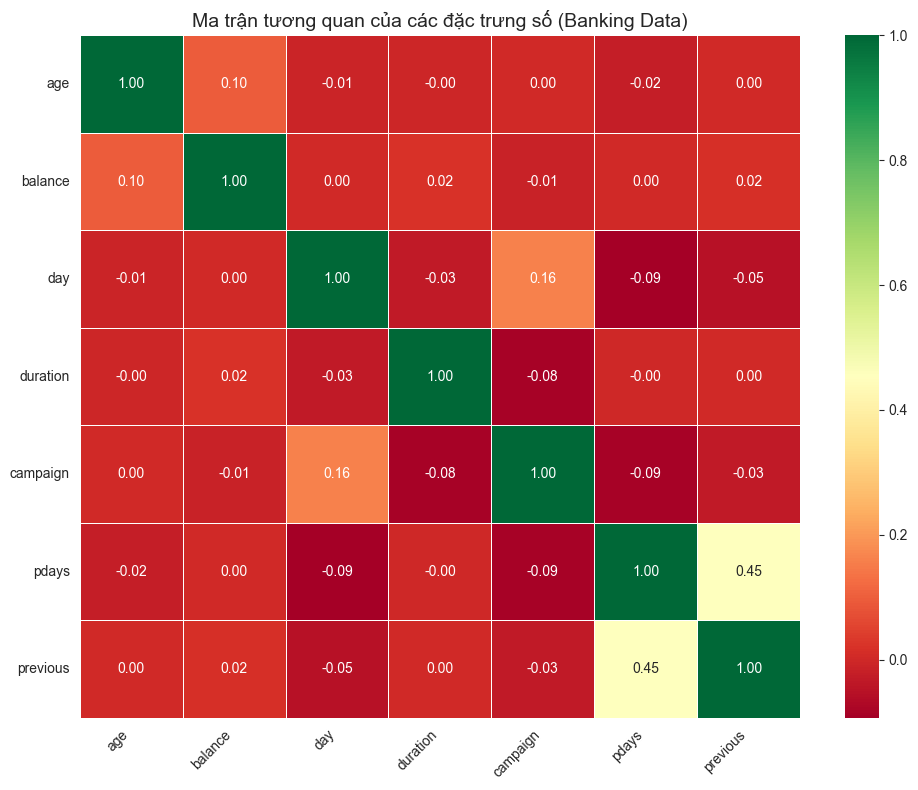

In [2]:
def spark_banking_correlation_heatmap(file_path, numerical_cols=None, figsize=(10, 8), cmap="RdYlGn"):
    """
    Vẽ biểu đồ nhiệt ma trận tương quan cho dữ liệu banking bằng Spark

    Parameters:
    - file_path: đường dẫn file banking-data.csv
    - numerical_cols: danh sách cột số (nếu None sẽ dùng mặc định)
    - figsize: kích thước biểu đồ
    - cmap: màu heatmap
    """

    # 1. Khởi tạo Spark
    spark = SparkSession.builder \
        .appName("Banking Correlation Heatmap") \
        .getOrCreate()

    # 2. Đọc dữ liệu
    df = spark.read.csv(file_path, header=True, inferSchema=True)

    # 3. Danh sách cột số mặc định
    if numerical_cols is None:
        numerical_cols = [
            "age",
            "balance",
            "day",
            "duration",
            "campaign",
            "pdays",
            "previous"
        ]

    # 4. Chọn dữ liệu số
    df_num = df.select(numerical_cols)

    # 5. Spark → Pandas
    pdf = df_num.toPandas()

    # 6. Tính ma trận tương quan
    corr_matrix = pdf.corr()

    # 7. Vẽ heatmap
    plt.figure(figsize=figsize)
    sns.heatmap(
        corr_matrix,
        annot=True,
        fmt=".2f",
        cmap=cmap,
        linewidths=0.5,
        cbar=True
    )

    plt.title("Ma trận tương quan của các đặc trưng số (Banking Data)", fontsize=14)
    plt.xticks(rotation=45, ha="right")
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

    # 8. Dừng Spark
    spark.stop()
spark_banking_correlation_heatmap("banking-data.csv")

# Tiền xử lý dữ liệu

Phân loại biến

In [5]:
categorical_cols = [
    'job','marital','education','default','housing','loan',
    'contact','month','poutcome'
]


numerical_cols = [
    'age','balance','day','duration','campaign','pdays','previous'
]


label_col = 'y'

Mã hóa cột phân loại

In [6]:
indexers = [StringIndexer(inputCol=c, outputCol=c+"_idx", handleInvalid="keep") for c in categorical_cols]
encoders = [OneHotEncoder(inputCol=c+"_idx", outputCol=c+"_vec") for c in categorical_cols]
pipeline = Pipeline(stages=indexers + encoders)
df = pipeline.fit(df).transform(df)
df.show(5)

+---+------------+-------+---------+-------+-------+-------+----+-------+---+-----+--------+--------+-----+--------+--------+---+-------+-----------+-------------+-----------+-----------+--------+-----------+---------+------------+---------------+-------------+-------------+-------------+-------------+-------------+-------------+--------------+-------------+
|age|         job|marital|education|default|balance|housing|loan|contact|day|month|duration|campaign|pdays|previous|poutcome|  y|job_idx|marital_idx|education_idx|default_idx|housing_idx|loan_idx|contact_idx|month_idx|poutcome_idx|        job_vec|  marital_vec|education_vec|  default_vec|  housing_vec|     loan_vec|  contact_vec|     month_vec| poutcome_vec|
+---+------------+-------+---------+-------+-------+-------+----+-------+---+-----+--------+--------+-----+--------+--------+---+-------+-----------+-------------+-----------+-----------+--------+-----------+---------+------------+---------------+-------------+-------------+---

Chuẩn hóa cột số

In [7]:
assembler_num = VectorAssembler(inputCols=numerical_cols, outputCol="num_features")
df = assembler_num.transform(df)
df.show(5)
scaler = StandardScaler(inputCol="num_features", outputCol="scaled_num_features")
df = scaler.fit(df).transform(df)
df.show(5)

+---+------------+-------+---------+-------+-------+-------+----+-------+---+-----+--------+--------+-----+--------+--------+---+-------+-----------+-------------+-----------+-----------+--------+-----------+---------+------------+---------------+-------------+-------------+-------------+-------------+-------------+-------------+--------------+-------------+--------------------+
|age|         job|marital|education|default|balance|housing|loan|contact|day|month|duration|campaign|pdays|previous|poutcome|  y|job_idx|marital_idx|education_idx|default_idx|housing_idx|loan_idx|contact_idx|month_idx|poutcome_idx|        job_vec|  marital_vec|education_vec|  default_vec|  housing_vec|     loan_vec|  contact_vec|     month_vec| poutcome_vec|        num_features|
+---+------------+-------+---------+-------+-------+-------+----+-------+---+-----+--------+--------+-----+--------+--------+---+-------+-----------+-------------+-----------+-----------+--------+-----------+---------+------------+-----

Tạo cột đặc trưng

In [8]:
assembler_all = VectorAssembler(
    inputCols=[c+"_vec" for c in categorical_cols] + ["scaled_num_features"],
    outputCol="features"
)
df = assembler_all.transform(df)
df.show(5)

+---+------------+-------+---------+-------+-------+-------+----+-------+---+-----+--------+--------+-----+--------+--------+---+-------+-----------+-------------+-----------+-----------+--------+-----------+---------+------------+---------------+-------------+-------------+-------------+-------------+-------------+-------------+--------------+-------------+--------------------+--------------------+--------------------+
|age|         job|marital|education|default|balance|housing|loan|contact|day|month|duration|campaign|pdays|previous|poutcome|  y|job_idx|marital_idx|education_idx|default_idx|housing_idx|loan_idx|contact_idx|month_idx|poutcome_idx|        job_vec|  marital_vec|education_vec|  default_vec|  housing_vec|     loan_vec|  contact_vec|     month_vec| poutcome_vec|        num_features| scaled_num_features|            features|
+---+------------+-------+---------+-------+-------+-------+----+-------+---+-----+--------+--------+-----+--------+--------+---+-------+-----------+---

Mã hóa biến mục tiêu

In [10]:
df = df.withColumn("label", when(col(label_col) == True, 1.0).otherwise(0.0))

In [11]:
df.describe(numerical_cols).show()

+-------+------------------+------------------+-----------------+-----------------+-----------------+------------------+------------------+
|summary|               age|           balance|              day|         duration|         campaign|             pdays|          previous|
+-------+------------------+------------------+-----------------+-----------------+-----------------+------------------+------------------+
|  count|             45211|             45211|            45211|            45211|            45211|             45211|             45211|
|   mean| 40.93621021432837|1362.2720576850766|15.80641879188693|258.1630797814691|2.763840658246887| 40.19782796222158|0.5803233726305546|
| stddev|10.618762040975405|3044.7658291685257|8.322476153044594|257.5278122651706|3.098020883279192|100.12874599059828| 2.303441044931218|
|    min|                18|             -8019|                1|                0|                1|                -1|                 0|
|    max|           

In [12]:
df.groupBy(label_col).count().show()

+---+-----+
|  y|count|
+---+-----+
| no|39922|
|yes| 5289|
+---+-----+



In [13]:
corr_matrix = Correlation.corr(df, "num_features").head()
print("Correlation matrix:\n", corr_matrix[0])

Correlation matrix:
 DenseMatrix([[ 1.        ,  0.09778274, -0.00912005, -0.00464843,  0.00476031,
              -0.02375801,  0.00128832],
             [ 0.09778274,  1.        ,  0.00450259,  0.02156038, -0.01457828,
               0.00343532,  0.01667364],
             [-0.00912005,  0.00450259,  1.        , -0.03020634,  0.16249022,
              -0.09304407, -0.0517105 ],
             [-0.00464843,  0.02156038, -0.03020634,  1.        , -0.0845695 ,
              -0.00156477,  0.00120306],
             [ 0.00476031, -0.01457828,  0.16249022, -0.0845695 ,  1.        ,
              -0.08862767, -0.03285529],
             [-0.02375801,  0.00343532, -0.09304407, -0.00156477, -0.08862767,
               1.        ,  0.45481964],
             [ 0.00128832,  0.01667364, -0.0517105 ,  0.00120306, -0.03285529,
               0.45481964,  1.        ]])


# Huấn luyện mô hình

Mô hình Logistic Regression

In [14]:
lr = LogisticRegression(featuresCol="features", labelCol='label')
paramGrid = ParamGridBuilder().addGrid(lr.regParam,[0.01, 0.1, 1.0]) \
                              .addGrid(lr.elasticNetParam, [0.0, 0.5, 1.0]) \
                              .build()
evaluator = BinaryClassificationEvaluator(labelCol='label', metricName="areaUnderROC")
crossVal = CrossValidator(estimator=lr, estimatorParamMaps=paramGrid,
                          evaluator=evaluator,
                          numFolds=10,
                          seed=42)
cv_model = crossVal.fit(df)
best_model = cv_model.bestModel
avg_metrics = cv_model.avgMetrics
print("AUC trung bình cho mỗi tham số kết hơp: ", avg_metrics)

predictions = best_model.transform(df)
auc = evaluator.evaluate(predictions)
print(f'ROC trên toàn bộ dữ liệu: {auc}')
print("\nAUC trung bình cho từng tổ hợp siêu tham số của LogisticRegression:")
param_combinations = [dict(param_map) for param_map in paramGrid]
results = []
for i, param_map in enumerate(param_combinations):
    param_str = {str(k.name): v for k, v in param_map.items()}
    results.append({**param_str, 'AUC': avg_metrics[i]})
df_results = pd.DataFrame(results)
print(df_results.to_string(index=False))

# Tính ROC trên toàn bộ dữ liệu
predictions_lr = best_model.transform(df)
auc_lr = evaluator.evaluate(predictions_lr)
print(f'ROC trên toàn bộ dữ liệu: {auc_lr}')

AUC trung bình cho mỗi tham số kết hơp:  [0.9077609095722886, 0.908062999323529, 0.9030795478408298, 0.9030309149466691, 0.8474874079304989, 0.8076246232472588, 0.8771054257590443, 0.5, 0.5]
ROC trên toàn bộ dữ liệu: 0.9086961444735937

AUC trung bình cho từng tổ hợp siêu tham số của LogisticRegression:
 regParam  elasticNetParam      AUC
     0.01              0.0 0.907761
     0.01              0.5 0.908063
     0.01              1.0 0.903080
     0.10              0.0 0.903031
     0.10              0.5 0.847487
     0.10              1.0 0.807625
     1.00              0.0 0.877105
     1.00              0.5 0.500000
     1.00              1.0 0.500000
ROC trên toàn bộ dữ liệu: 0.9086961444735937


Mô hình Random Forest

In [15]:
rf = RandomForestClassifier(featuresCol="features", labelCol="label")
paramGrid = ParamGridBuilder() \
    .addGrid(rf.numTrees, [50, 100]) \
    .addGrid(rf.maxDepth, [5, 10]) \
    .build()
crossVal = CrossValidator(estimator=rf,
                          estimatorParamMaps=paramGrid,
                          evaluator=evaluator,
                          numFolds=10,
                          seed=42)
cv_model = crossVal.fit(df)
best_model = cv_model.bestModel
avg_metrics = cv_model.avgMetrics
print("AUC trung bình cho mỗi tham số kết hơp: ", avg_metrics)
predictions = best_model.transform(df)
auc = evaluator.evaluate(predictions)
print(f"ROC trên toàn bộ dữ liệu: {auc}")
print("\nAUC trung bình cho từng tổ hợp siêu tham số của RandomForestClassifier:")
param_combinations = [dict(param_map) for param_map in paramGrid]
results = []
for i, param_map in enumerate(param_combinations):
    param_str = {str(k.name): v for k, v in param_map.items()}
    results.append({**param_str, 'AUC': avg_metrics[i]})
df_results = pd.DataFrame(results)
print(df_results.to_string(index=False))

# Tính ROC trên toàn bộ dữ liệu
predictions_rf = best_model.transform(df)
auc_rf = evaluator.evaluate(predictions_rf)
print(f"ROC trên toàn bộ dữ liệu: {auc_rf}")

AUC trung bình cho mỗi tham số kết hơp:  [0.8927677077969177, 0.9199650893759298, 0.896327429366201, 0.9213661022254571]
ROC trên toàn bộ dữ liệu: 0.9407627322702576

AUC trung bình cho từng tổ hợp siêu tham số của RandomForestClassifier:
 numTrees  maxDepth      AUC
       50         5 0.892768
       50        10 0.919965
      100         5 0.896327
      100        10 0.921366
ROC trên toàn bộ dữ liệu: 0.9407627322702576


Mô hình Grandient Booting Classifier

In [16]:
gbt = GBTClassifier(featuresCol="features", labelCol="label", seed=42)
paramGrid = ParamGridBuilder() \
    .addGrid(gbt.maxIter, [10, 20]) \
    .addGrid(gbt.maxDepth, [5, 10]) \
    .addGrid(gbt.stepSize, [0.1, 0.01]) \
    .build()
evaluator = BinaryClassificationEvaluator(labelCol="label", metricName="areaUnderROC")
crossval = CrossValidator(estimator=gbt,
                          estimatorParamMaps=paramGrid,
                          evaluator=evaluator,
                          numFolds=10,
                          seed=42)
cv_model = crossval.fit(df)
best_model = cv_model.bestModel
avg_metrics = cv_model.avgMetrics
print("AUC trung bình cho mỗi tham số kết hơp: ", avg_metrics)
predictions = best_model.transform(df)
auc = evaluator.evaluate(predictions)
print(f"ROC trên toàn bộ dữ liệu: {auc}")
# Hiển thị AUC cho từng tổ hợp siêu tham số
print("\nAUC trung bình cho từng tổ hợp siêu tham số của GBTClassifier:")
param_combinations = [dict(param_map) for param_map in paramGrid]
results = []
for i, param_map in enumerate(param_combinations):
    param_str = {str(k.name): v for k, v in param_map.items()}
    results.append({**param_str, 'AUC': avg_metrics[i]})
df_results = pd.DataFrame(results)
print(df_results.to_string(index=False))

# Tính ROC trên toàn bộ dữ liệu
predictions_gbt = best_model.transform(df)
auc_gbt = evaluator.evaluate(predictions_gbt)
print(f"ROC trên toàn bộ dữ liệu: {auc_gbt}")

AUC trung bình cho mỗi tham số kết hơp:  [0.9107447168994831, 0.8827873718549935, 0.9127680016687147, 0.8874695413707718, 0.9205599080331364, 0.8895255398996269, 0.9193977025330753, 0.896347253336508]
ROC trên toàn bộ dữ liệu: 0.929755682874477

AUC trung bình cho từng tổ hợp siêu tham số của GBTClassifier:
 maxIter  maxDepth  stepSize      AUC
      10         5      0.10 0.910745
      10         5      0.01 0.882787
      10        10      0.10 0.912768
      10        10      0.01 0.887470
      20         5      0.10 0.920560
      20         5      0.01 0.889526
      20        10      0.10 0.919398
      20        10      0.01 0.896347
ROC trên toàn bộ dữ liệu: 0.929755682874477


In [17]:
numerical_cols_with_label = numerical_cols + ["label"]
assembler = VectorAssembler(inputCols=numerical_cols_with_label, outputCol="features_with_label")
corr_matrix = Correlation.corr(assembler.transform(df), "features_with_label").head()[0]
print("Correlation matrix:\n", corr_matrix)

Correlation matrix:
 DenseMatrix([[ 1.        ,  0.09778274, -0.00912005, -0.00464843,  0.00476031,
              -0.02375801,  0.00128832,  0.02515502],
             [ 0.09778274,  1.        ,  0.00450259,  0.02156038, -0.01457828,
               0.00343532,  0.01667364,  0.05283841],
             [-0.00912005,  0.00450259,  1.        , -0.03020634,  0.16249022,
              -0.09304407, -0.0517105 , -0.02834778],
             [-0.00464843,  0.02156038, -0.03020634,  1.        , -0.0845695 ,
              -0.00156477,  0.00120306,  0.39452102],
             [ 0.00476031, -0.01457828,  0.16249022, -0.0845695 ,  1.        ,
              -0.08862767, -0.03285529, -0.07317201],
             [-0.02375801,  0.00343532, -0.09304407, -0.00156477, -0.08862767,
               1.        ,  0.45481964,  0.10362149],
             [ 0.00128832,  0.01667364, -0.0517105 ,  0.00120306, -0.03285529,
               0.45481964,  1.        ,  0.09323577],
             [ 0.02515502,  0.05283841, -0.02834

In [18]:
spark.stop()